In [482]:
player = next(p for p in st.freeagents if p.position in st.GetMoves())
player

Aaron Judge_OF_9_pts

In [492]:
st.GetMoves()

['IF', 'OF', 'P']

In [501]:
import math
from random import choices
players = [p.name for p in state.freeagents]
adp_p = [(num_competitors * num_rounds / len(turns)) / p.adp for p in state.freeagents]

st = state.Clone()
st.DoAdpMove()

In [526]:
st.GetResult(st.playerJustMoved)

70.98666666666666

In [545]:
min([np.random.normal(loc = p.adp) for p in st.freeagents if p.position == 'P'])

11.788015361694914

In [538]:
def adp_draft(self):
    st = self.Clone()
    p_players = [np.random.normal(loc = p.adp) for p in st.freeagents if p.position == 'P']
    p_min_val, p_min_player = min(p_players), p_players.index(min(p_players))
    if_players,  = [np.random.normal(loc = p.adp) for p in st.freeagents if p.position == 'IF']
    of_players = [np.random.normal(loc = p.adp) for p in st.freeagents if p.position == 'OF']
    


In [563]:
import pandas as pd
import numpy as np

class DraftState:
    def __init__(self, rosters, turns, freeagents, playerjm=None):
        self.rosters = rosters
        self.freeagents = freeagents
        self.turns = turns
        self.playerJustMoved = playerjm

class MLBPlayer:
    def __init__(self, name, team, position, points, adp, adj_pts):
        self.name = name
        self.team = team
        self.position = str(position)
        self.points = points
        self.adp = adp
        self.adj_pts = adj_pts
        
    def __repr__(self):
        #return self.name
        return "_".join([self.name, self.position, str(round(self.points)), 'pts'])
    def pop(self, index=-1) :
        return self.data.pop(index)

def GetResult(self, playerjm):
    """ Get the game result from the viewpoint of playerjm.
    """
    if playerjm is None: return 0
    
    pos_wgts = {
        ("IF"): [1, 1],
        ("OF"): [1, 1],
        ("P"): [1],
        ("IF", "OF"):[.7]
        # ("SS"): [1],
        # ('3B'): [1],
        # # ("1B", "3B"): [.6, .4],
        # # ("2B", "SS"): [.6, .4],
        # # ('LF'):[.3],
        # # ('CF'):[.3],
        # ('OF'):[1],
        # ("C", "1B", "2B", "SS", "3B", 'DH'): [1],
        # ("SP"): [1],
        # ("RP"): [1]
    }
    result = 0
    # map the drafted players to the weights
    for p in self.rosters[playerjm]:
        max_wgt, _, max_pos, old_wgts = max(
            ((wgts[0], -len(lineup_pos), lineup_pos, wgts) for lineup_pos, wgts in pos_wgts.items()
                if p.position in lineup_pos),
            default=(0, 0, (), []))
        if max_wgt > 0:
            result += max_wgt * p.points
            old_wgts.pop(0)
            if not old_wgts:
                pos_wgts.pop(max_pos)
                
    # map the remaining weights to the top three free agents
    for pos, wgts in pos_wgts.items():
        result += np.mean([p.points for p in self.freeagents if p.position in pos][:3]) * sum(wgts)
    return result
DraftState.GetResult = GetResult

def GetMoves(self):
    """ Get all possible moves from this state.
    """
    
    pos_max = {"IF": 3, "OF": 3, "P": 1}
    if len(self.turns) == 0: return []
    roster_positions = np.array([p.position for p in self.rosters[self.turns[0]]], dtype=str)
    moves = [pos for pos, max_ in pos_max.items() if np.sum(roster_positions == pos) < max_]
    #moves = list(pos_max.keys())
    return moves
DraftState.GetMoves = GetMoves

def DoMove(self, move):
    """ Update a state by carrying out the given move.
        Must update playerJustMoved.
    """
    player = next(p for p in self.freeagents if p.position == move)
    self.freeagents.remove(player)
    rosterId = self.turns.pop(0)
    self.rosters[rosterId].append(player)
    self.playerJustMoved = rosterId
    
DraftState.DoMove = DoMove

def DoGreedyMove(self, move):
    """ Update a state by carrying out the greediest (most points at the moment) move.
        Must update playerJustMoved.
    """
    # Get the next highest player from the eligible player pool (i.e. you can't draft an 8th IF if you have 7 already)
    player = next(p for p in self.freeagents if p.position == move)
    self.freeagents.remove(player)
    rosterId = self.turns.pop(0)
    self.rosters[rosterId].append(player)
    self.playerJustMoved = rosterId
    
DraftState.DoGreedyMove = DoGreedyMove

def DoAdpMove(self):
    moves = self.GetMoves()
    fa_subset = [p for p in self.freeagents if p.position in moves]
    players = [np.random.normal(loc = p.adp) for p in self.freeagents if p.position in moves]
    ind = players.index(min(players))
    player = fa_subset[ind]
    self.freeagents.remove(player)
    rosterId = self.turns.pop(0)
    self.rosters[rosterId].append(player)
    self.playerJustMoved = rosterId

DraftState.DoAdpMove = DoAdpMove

def DoManualMove(self, player_name):
    """ Update a state by carrying out a specific move.
        Must update playerJustMoved.
    """
    player = [p for p in self.freeagents if p.name == player_name][0]
    self.freeagents.remove(player)
    rosterId = self.turns.pop(0)
    self.rosters[rosterId].append(player)
    self.playerJustMoved = rosterId
    
DraftState.DoManualMove = DoManualMove

def Clone(self):
    """ Create a deep clone of this game state.
    """
    rosters = list(map(lambda r: r[:], self.rosters))
    st = DraftState(rosters, self.turns[:], self.freeagents[:],
            self.playerJustMoved)
    return st
DraftState.Clone = Clone

# Add other strategies:

def greedy_draft(self):
    def result(move):
        st = self.Clone()
        st.DoMove(move)
        return st.GetResult(st.playerJustMoved)
    
    res, move = max((result(m), m) for m in self.GetMoves())
    return move
DraftState.greedy_draft = greedy_draft

def random_draft(self):
    return np.random.choice(self.GetMoves())
DraftState.random_draft = random_draft


# This is a very simple implementation of the UCT Monte Carlo Tree Search algorithm in Python 2.7.
# The function UCT(rootstate, itermax, verbose = False) is towards the bottom of the code.
# It aims to have the clearest and simplest possible code, and for the sake of clarity, the code
# is orders of magnitude less efficient than it could be made, particularly by using a 
# state.GetRandomMove() or state.DoRandomRollout() function.
# 
# Written by Peter Cowling, Ed Powley, Daniel Whitehouse (University of York, UK) September 2012.
# 
# Licence is granted to freely use and distribute for any sensible/legal purpose so long as this comment
# remains in any distributed code.
# 
# For more information about Monte Carlo Tree Search check out our web site at www.mcts.ai
from math import *
import random
class Node:
    """ A node in the game tree. Note wins is always from the viewpoint of playerJustMoved.
        Crashes if state not specified.
    """
    def __init__(self, move = None, parent = None, state = None):
        self.move = move # the move that got us to this node - "None" for the root node
        self.parentNode = parent # "None" for the root node
        self.childNodes = []
        self.wins = 0
        self.visits = 0
        self.untriedMoves = state.GetMoves() # future child nodes
        self.playerJustMoved = state.playerJustMoved # the only part of the state that the Node needs later
        
    def UCTSelectChild(self):
        """ Use the UCB1 formula to select a child node. Often a constant UCTK is applied so we have
            lambda c: c.wins/c.visits + UCTK * sqrt(2*log(self.visits)/c.visits to vary the amount of
            exploration versus exploitation.
        """
        UCTK = 200
        s = sorted(self.childNodes, key = lambda c: c.wins/c.visits + UCTK * sqrt(2*log(self.visits)/c.visits))[-1]
        return s
    
    def AddChild(self, m, s):
        """ Remove m from untriedMoves and add a new child node for this move.
            Return the added child node
        """
        n = Node(move = m, parent = self, state = s)
        self.untriedMoves.remove(m)
        self.childNodes.append(n)
        return n
    
    def Update(self, result):
        """ Update this node - one additional visit and result additional wins. result must be from the viewpoint of playerJustmoved.
        """
        self.visits += 1
        self.wins += result
def UCT(rootstate, itermax, verbose = False):
    """ Conduct a UCT search for itermax iterations starting from rootstate.
        Return the best move from the rootstate.
    """
    rootnode = Node(state = rootstate)
    for i in range(itermax):
        node = rootnode
        state = rootstate.Clone()
        # Select
        while node.untriedMoves == [] and node.childNodes != []: # node is fully expanded and non-terminal
            node = node.UCTSelectChild()
            state.DoMove(node.move)
        # Expand
        if node.untriedMoves != []: # if we can expand (i.e. state/node is non-terminal)
            m = random.choice(node.untriedMoves) 
            state.DoMove(m)
            node = node.AddChild(m,state) # add child and descend tree
        # Rollout - this can often be made orders of magnitude quicker using a state.GetRandomMove() function
        while state.GetMoves() != []: # while state is non-terminal
            state.DoMove(random.choice(state.GetMoves()))
        # Backpropagate
        while node != None: # backpropagate from the expanded node and work back to the root node
            node.Update(state.GetResult(node.playerJustMoved)) # state is terminal. Update node with result from POV of node.playerJustMoved
            node = node.parentNode
    return sorted(rootnode.childNodes, key = lambda c: c.visits)[-1].move # return the move that was most visited

# Read in data

In [574]:
mlb_players = pd.read_csv("~/Documents/GitHub/fantasy_baseball_draft_bot/data/underdog_daily_data/cleaned/opening day_2.csv")

freeagents = [MLBPlayer(*p) for p in mlb_players.itertuples(index=False, name=None)]

num_competitors = 6
rosters = [[] for _ in range(num_competitors)] # empty rosters to start with

num_rounds = 6
turns = []
# generate turns by snake order
for i in range(num_rounds):
    turns += reversed(range(num_competitors)) if i % 2 else range(num_competitors)
    
state = DraftState(rosters, turns, freeagents)
iterations = 1000

# Bots against themselves (using MCTS)

In [332]:
while state.GetMoves() != []:
    move = UCT(state, iterations)
    state.DoMove(move)
    #print((state.rosters[state.playerJustMoved][-1], move), end=".")
    print(state.rosters[state.playerJustMoved][-1], end=").(")


Freddie Freeman_IF_1681_pts).(Aaron Judge_OF_1601_pts).(José Ramírez_IF_1642_pts).(Ronald Acuña Jr._OF_1540_pts).(Trea Turner_IF_1577_pts).(Juan Soto_OF_1515_pts).(Gerrit Cole_P_1290_pts).(Paul Goldschmidt_IF_1541_pts).(Yordan Alvarez_OF_1485_pts).(Vladimir Guerrero Jr._IF_1529_pts).(Julio Rodríguez_OF_1461_pts).(Shohei Ohtani_OF_1448_pts).(Manny Machado_IF_1506_pts).(Shane Bieber_P_1246_pts).(Corbin Burnes_P_1242_pts).(Mookie Betts_OF_1426_pts).(Mike Trout_OF_1395_pts).(Pete Alonso_IF_1465_pts).(Marcus Semien_IF_1458_pts).(Aaron Nola_P_1181_pts).(Matt Olson_IF_1444_pts).(Kyle Tucker_OF_1368_pts).(Yu Darvish_P_1155_pts).(Sandy Alcantara_P_1125_pts).(Rafael Devers_IF_1411_pts).(Austin Riley_IF_1407_pts).(Framber Valdez_P_1123_pts).(Robbie Ray_P_1116_pts).(Bobby Witt Jr._IF_1402_pts).(Kevin Gausman_P_1116_pts).(Kyle Schwarber_OF_1304_pts).(Max Scherzer_P_1111_pts).(Spencer Strider_P_1099_pts).(Brandon Woodruff_P_1099_pts).(Bo Bichette_IF_1361_pts).(Shane McClanahan_P_1096_pts).(Dylan Cea

In [334]:
df_export = pd.DataFrame({"Team " + str(i + 1): r for i, r in enumerate(state.rosters)})
df_export.to_csv('~/Documents/GitHub/fantasy_baseball_draft_bot/data/mcts_results_raw_points.csv', index=False)


In [573]:
tm1 = pd.DataFrame([r.name for i, r in enumerate(state.rosters[0])])
tm2 = pd.DataFrame([r.name for i, r in enumerate(state.rosters[1])])
tm3 = pd.DataFrame([r.name for i, r in enumerate(state.rosters[2])])
tm4 = pd.DataFrame([r.name for i, r in enumerate(state.rosters[3])])
tm5 = pd.DataFrame([r.name for i, r in enumerate(state.rosters[4])])
tm6 = pd.DataFrame([r.name for i, r in enumerate(state.rosters[5])])
tm7 = pd.DataFrame([r.name for i, r in enumerate(state.rosters[6])])
tm8 = pd.DataFrame([r.name for i, r in enumerate(state.rosters[7])])
tm9 = pd.DataFrame([r.name for i, r in enumerate(state.rosters[8])])
tm10 = pd.DataFrame([r.name for i, r in enumerate(state.rosters[9])])
tm11 = pd.DataFrame([r.name for i, r in enumerate(state.rosters[10])])
tm12 = pd.DataFrame([r.name for i, r in enumerate(state.rosters[11])])
results = pd.concat([tm1, tm2, tm3, tm4, tm5, tm6, tm7, tm8, tm9, tm10, tm11, tm12], axis = 1)
results.columns = ['tm1', 'tm2', 'tm3', 'tm4', 'tm5', 'tm6', 'tm7', 'tm8', 'tm9', 'tm10', 'tm11', 'tm12']
results

IndexError: list index out of range

# MCTS vs Random

In [381]:
state1 = state.Clone()
state2 = state.Clone()
it = 3000
while state1.GetMoves() != []:
    if state1.turns[0] % 2:
        move1 = UCT(state1, it)
        move2 = random_draft(state2)
    else:
        move1 = random_draft(state1)
        move2 = UCT(state2, it)
    print(move1, end=".")
    state1.DoMove(move1)
    print(move2, end=".")
    state2.DoMove(move2)

results1 = [sum(p.points for p in r) for r in state1.rosters]
results2 = [sum(p.points for p in r) for r in state2.rosters] 
results1 = np.reshape(results1, (-1, 2))
results2 = np.reshape(results2, (-1, 2))
random_res = np.ravel(np.hstack((results1[:, 0], results2[:, 1])))
mcts_res = np.ravel(np.hstack((results2[:, 0], results1[:, 1])))

P.P.OF.OF.IF.P.P.OF.IF.OF.P.P.OF.P.P.P.IF.P.P.IF.OF.IF.P.P.IF.OF.OF.P.IF.IF.P.IF.IF.OF.P.IF.IF.IF.IF.IF.IF.OF.IF.OF.IF.P.OF.OF.IF.OF.IF.OF.IF.OF.OF.IF.P.OF.OF.IF.OF.OF.OF.OF.OF.OF.OF.OF.P.IF.IF.IF.IF.OF.IF.IF.OF.IF.OF.IF.IF.IF.OF.IF.OF.IF.OF.P.IF.P.P.IF.IF.IF.IF.OF.IF.IF.P.OF.OF.OF.OF.IF.IF.OF.OF.OF.IF.OF.OF.OF.OF.IF.OF.P.IF.OF.OF.OF.OF.IF.OF.OF.IF.OF.IF.OF.IF.IF.IF.IF.IF.OF.OF.IF.OF.OF.OF.IF.OF.IF.OF.IF.

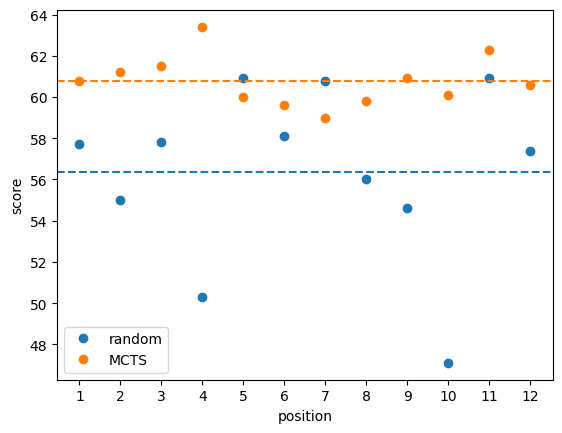

In [382]:
import matplotlib.pyplot as plt
fig, ax = plt.subplots()
ax.plot([str(i + 1) for i in range(num_competitors)], random_res, 'o', label="random")
ax.axhline(np.mean(random_res), ls='--', c='tab:blue')
ax.plot([str(i + 1) for i in range(num_competitors)], mcts_res, 'o', label='MCTS')
ax.axhline(np.mean(mcts_res), ls='--', c='tab:orange')
ax.set(xlabel="position", ylabel="score")
ax.legend()
fig.savefig("random.png")
plt.show()

# UCT vs Greedy

In [388]:
state1 = state.Clone()
state2 = state.Clone()
it = 10000
while state1.GetMoves() != []:
    if state1.turns[0] % 2:
        move1 = UCT(state1, it)
        move2 = greedy_draft(state2)
    else:
        move1 = greedy_draft(state1)
        move2 = UCT(state2, it)
    print(move1, end=".")
    state1.DoMove(move1)
    print(move2, end=".")
    state2.DoMove(move2)

results1 = [sum(p.points for p in r) for r in state1.rosters]
results2 = [sum(p.points for p in r) for r in state2.rosters] 
results1 = np.reshape(results1, (-1, 2))
results2 = np.reshape(results2, (-1, 2))
greedy_res = np.ravel(np.hstack((results1[:, 0], results2[:, 1])))
mcts2_res = np.ravel(np.hstack((results2[:, 0], results1[:, 1])))

P.P.P.P.IF.OF.OF.IF.IF.P.P.P.P.P.P.P.P.P.P.P.P.IF.IF.P.IF.IF.IF.IF.OF.IF.OF.OF.OF.OF.OF.OF.OF.OF.P.OF.OF.P.P.OF.OF.OF.OF.OF.OF.OF.OF.IF.OF.IF.OF.IF.IF.OF.IF.OF.IF.OF.IF.IF.IF.IF.IF.IF.IF.IF.IF.IF.OF.IF.IF.OF.IF.OF.IF.OF.OF.IF.OF.IF.OF.OF.OF.OF.P.OF.OF.OF.OF.OF.OF.OF.IF.IF.IF.OF.IF.IF.IF.IF.IF.IF.OF.IF.IF.IF.IF.IF.OF.OF.OF.OF.OF.OF.OF.OF.OF.OF.OF.OF.OF.OF.OF.IF.OF.OF.OF.OF.IF.IF.OF.IF.IF.OF.IF.IF.IF.IF.IF.IF.

In [ ]:
greedy_res, mcts2_res

(array([60.5, 60.7, 56.2, 60.1, 61.1, 58.2, 61.9, 57.6, 58.4, 58.4, 56.1,
        58.7]),
 array([60.1, 59.5, 60. , 62.2, 51.8, 56.7, 61.2, 58.5, 50.1, 59.3, 57.5,
        57.6]))

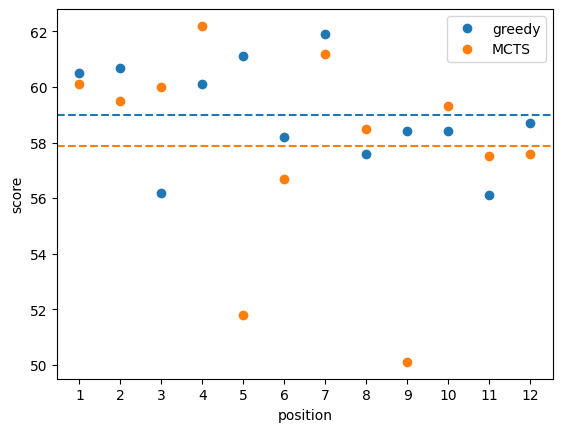

In [ ]:
fig, ax = plt.subplots()
ax.plot([str(i + 1) for i in range(num_competitors)], greedy_res, 'o', label="greedy")
ax.axhline(np.mean(greedy_res), ls='--', c='tab:blue')
ax.plot([str(i + 1) for i in range(num_competitors)], mcts2_res, 'o', label='MCTS')
ax.axhline(np.mean(mcts2_res), ls='--', c='tab:orange')
ax.set(xlabel="position", ylabel="score")
ax.legend()
fig.savefig("greedy.png")
plt.show()

In [503]:
state3 = state.Clone()
it = 3000
while state3.GetMoves() != []:
    if state3.turns[0] % 2 == 0:
        move1 = greedy_draft(state3)
        state3.DoGreedyMove(move1)
    else:
        move2 = UCT(state3, it)
        state3.DoMove(move2)
    print(state3.rosters[state3.playerJustMoved][-1], end=").(")

# results1 = [sum(p.points for p in r) for r in state1.rosters]
# results2 = [sum(p.points for p in r) for r in state2.rosters] 
# results1 = np.reshape(results1, (-1, 2))
# results2 = np.reshape(results2, (-1, 2))
# greedy_res = np.ravel(np.hstack((results1[:, 0], results2[:, 1])))
# mcts2_res = np.ravel(np.hstack((results2[:, 0], results1[:, 1])))

Ronald Acuña Jr._OF_15_pts).(Austin Riley_IF_13_pts).(Gerrit Cole_P_14_pts).(

KeyboardInterrupt: 

In [ ]:
# df_export_2 = pd.DataFrame({"Team " + str(i + 1): r for i, r in enumerate(state1.rosters)})
# df_export_2.to_csv('~/Documents/GitHub/fantasy_baseball_draft_bot/data/mcts_results_uct_vs_greedy.csv', index=False)

# df_export_3 = pd.DataFrame({"Team " + str(i + 1): r for i, r in enumerate(state2.rosters)})
# df_export_3.to_csv('~/Documents/GitHub/fantasy_baseball_draft_bot/data/mcts_results_uct_vs_greedy_2.csv', index=False)

df_export_4 = pd.DataFrame({"Team " + str(i + 1): r for i, r in enumerate(state3.rosters)})
df_export_4.to_csv('~/Documents/GitHub/fantasy_baseball_draft_bot/data/mcts_results_uct_vs_greedy_3.csv', index=False)

# UCT vs ADP

In [565]:
state4 = state.Clone()
it = 1000
while state4.GetMoves() != []:
    if state4.turns[0] % 2 == 0:
        state4.DoAdpMove()
    else:
        move2 = UCT(state4, it)
        state4.DoMove(move2)
    print(state4.rosters[state4.playerJustMoved][-1], end=").(")

# results1 = [sum(p.points for p in r) for r in state1.rosters]
# results2 = [sum(p.points for p in r) for r in state2.rosters] 
# results1 = np.reshape(results1, (-1, 2))
# results2 = np.reshape(results2, (-1, 2))
# greedy_res = np.ravel(np.hstack((results1[:, 0], results2[:, 1])))
# mcts2_res = np.ravel(np.hstack((results2[:, 0], results1[:, 1])))

Aaron Judge_OF_9_pts).(Ronald Acuña Jr._OF_15_pts).(Mike Trout_OF_11_pts).(Austin Riley_IF_13_pts).(Shohei Ohtani_OF_10_pts).(Juan Soto_OF_12_pts).(Gerrit Cole_P_14_pts).(Trea Turner_IF_10_pts).(Corbin Burnes_P_14_pts).(Freddie Freeman_IF_10_pts).(Rafael Devers_IF_11_pts).(Julio Rodríguez_OF_9_pts).(Max Scherzer_P_13_pts).(Ozzie Albies_IF_12_pts).(José Ramírez_IF_10_pts).(Matt Olson_IF_12_pts).(Byron Buxton_OF_10_pts).(Oneil Cruz_IF_12_pts).(Cedric Mullins_OF_11_pts).(Yordan Alvarez_OF_10_pts).(Michael Harris II_OF_11_pts).(Jacob deGrom_P_12_pts).(Jake Fraley_OF_11_pts).(Mookie Betts_OF_10_pts).(Vladimir Guerrero Jr._IF_9_pts).(Shane McClanahan_P_13_pts).(Manny Machado_IF_11_pts).(Adley Rutschman_IF_11_pts).(Luis Urías_IF_8_pts).(Tyler Stephenson_IF_11_pts).(Triston Casas_IF_11_pts).(Pete Alonso_IF_8_pts).(Bryan Reynolds_OF_10_pts).(Randy Arozarena_OF_9_pts).(Sean Murphy_IF_10_pts).(Christian Vázquez_IF_8_pts).(

In [566]:
df_export_5 = pd.DataFrame({"Team " + str(i + 1): r for i, r in enumerate(state4.rosters)})
df_export_5.to_csv('~/Documents/GitHub/fantasy_baseball_draft_bot/data/mcts_results_uct_vs_adp.csv', index=False)

In [567]:
state5 = state.Clone()

In [568]:
temp = state5.Clone()
state5.DoManualMove('Aaron Judge')

In [569]:
temp.rosters

[[], [], [], [], [], []]

In [570]:
state5.rosters

[[Aaron Judge_OF_9_pts], [], [], [], [], []]

In [571]:
state.freeagents

[Ronald Acuña Jr._OF_15_pts,
 Aaron Judge_OF_9_pts,
 Mike Trout_OF_11_pts,
 Austin Riley_IF_13_pts,
 Gerrit Cole_P_14_pts,
 Juan Soto_OF_12_pts,
 Corbin Burnes_P_14_pts,
 Max Scherzer_P_13_pts,
 Shane McClanahan_P_13_pts,
 Hunter Greene_P_13_pts,
 Shane Bieber_P_13_pts,
 Jacob deGrom_P_12_pts,
 Aaron Nola_P_12_pts,
 Rafael Devers_IF_11_pts,
 Ozzie Albies_IF_12_pts,
 Matt Olson_IF_12_pts,
 Oneil Cruz_IF_12_pts,
 Shohei Ohtani_OF_10_pts,
 Blake Snell_P_11_pts,
 Manny Machado_IF_11_pts,
 Cedric Mullins_OF_11_pts,
 Julio Urías_P_11_pts,
 Adley Rutschman_IF_11_pts,
 Michael Harris II_OF_11_pts,
 Byron Buxton_OF_10_pts,
 Zac Gallen_P_11_pts,
 Tyler Stephenson_IF_11_pts,
 Freddie Freeman_IF_10_pts,
 Trea Turner_IF_10_pts,
 Max Fried_P_11_pts,
 Jake Fraley_OF_11_pts,
 Framber Valdez_P_11_pts,
 Pablo López_P_11_pts,
 Triston Casas_IF_11_pts,
 Yordan Alvarez_OF_10_pts,
 Sean Murphy_IF_10_pts,
 Travis d'Arnaud_IF_10_pts,
 Bryan Reynolds_OF_10_pts,
 Sandy Alcantara_P_10_pts,
 Jonathan India_IF_10_